In [2]:
import tensorflow as tf
import os
from GPVAEmodel import *
from utils import *

# Restore Model

In [1]:
# for SIN model
# chkpnt_dir = "/home/michael/GPVAE_checkpoints/84:__on__9_10_2019__at__19:15:31/"
SIN_chkpnt_dir = "/run/user/1000/gvfs/sftp:host=godzilla/home/maths/phrnaj/GPVAE_checkpoints/Ayman2/6:SIN_huanan/"
VAE_chkpnt_dir = "/run/user/1000/gvfs/sftp:host=godzilla/home/maths/phrnaj/GPVAE_checkpoints/Ayman2/71:VAE_huanan/"
trainelbo = "SIN"

In [22]:
pic_folder = chkpnt_dir + "pics/"
res_file = chkpnt_dir + "res/ELBO_pandas"


px = 32
py = 32
r = 3
vid_lt = 5
model_lt = 5.0

# Load test batch from HDD
with open(os.getenv("HOME")+"/GPVAE/Test_Batches.pkl", "rb") as f:
    Test_Batches = pickle.load(f)


def get_qnet(video, model='SIN'):
    
    if model=='SIN':
        chkpnt_dir = SIN_chkpnt_dir
    else:
        chkpnt_dir = VAE_chkpnt_dir

    # Data settings
    batch = video.shape[0]
    tmax = video.shape[1]
    
    # make sure everything is created in the same graph!
    graph = tf.Graph()
    with graph.as_default():

        # Make all the graphs
        beta = tf.compat.v1.placeholder(dtype=tf.float32, shape=())
        vid_batch = build_video_batch_graph(batch=batch, tmax=tmax, px=px, py=py, r=r, lt=vid_lt)
        s_elbo, s_rec, s_pkl, np_elbo, np_rec, np_pkl, \
            p_m,p_v,q_m,q_v,pred_vid, globs = build_sin_and_np_elbo_graphs2(vid_batch, beta, lt=model_lt)

        # The actual loss functions!
        if trainelbo=="SIN":
            loss  = -tf.reduce_mean(s_elbo)
            e_elb = tf.reduce_mean(s_elbo)
            e_pkl = tf.reduce_mean(s_pkl)
            e_rec = tf.reduce_mean(s_rec)
        elif trainelbo=="NP":
            loss  = -tf.reduce_mean(np_elbo)
            e_elb = tf.reduce_mean(np_elbo)
            e_pkl = tf.reduce_mean(np_pkl)
            e_rec = tf.reduce_mean(np_rec)

        av_s_elbo = tf.reduce_mean(s_elbo)
        av_s_rec  = tf.reduce_mean(s_rec)
        av_s_pkl  = tf.reduce_mean(s_pkl)


        # Add optimizer ops to graph (minimizing neg elbo!), print out trainable vars
        global_step = tf.Variable(0, name='global_step',trainable=False)
        optimizer  = tf.compat.v1.train.AdamOptimizer()
        train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
        optim_step = optimizer.minimize(loss=loss, 
                                        var_list=train_vars,
                                        global_step=global_step)
        print("\n\nTrainable variables:")
        for v in train_vars:
            print(v)


        # Initializer ops for the graph and saver
        init_op = tf.global_variables_initializer()
        saver = tf.compat.v1.train.Saver()


        # Results to be tracked and Pandas saver
        res_vars = [global_step,
                    loss,
                    av_s_elbo,
                    av_s_rec,
                    av_s_pkl,
                    e_elb,
                    e_rec,
                    e_pkl,
                    tf.math.reduce_min(q_v),
                    tf.math.reduce_max(q_v),
                    tf.math.reduce_min(p_v),
                    tf.math.reduce_max(p_v)]
        res_names= ["Step",
                    "Loss",
                    "Test ELBO",
                    "Test Reconstruction",
                    "Test Prior KL",
                    "Train ELBO",
                    "Train Reconstruction",
                    "Train Prior KL",
                    "min qs_var",
                    "max qs_var",
                    "min q_var",
                    "max q_var",
                    "MSE",
                    "Beta",
                    "Time"]
        res_saver = pandas_res_saver(res_file, res_names)

        # Now let's start doing some computation!
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
        with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:

            # Attempt a restore weights
#             try:
            saver.restore(sess, tf.train.latest_checkpoint(chkpnt_dir))
            print("\n\nRestored Model Weights")
#             except:
#                 sess.run(init_op)
#                 print("\n\nInitialised Model Weights")

            # Start training that elbo!
            for t in range(1):

                # get training step
                g_s = sess.run(global_step, {beta:1.0})

                # Print out diagnostics/tracking
                TD = video
                test_elbo, e_rec_i, e_pkl_i = sess.run([e_elb, e_rec, e_pkl], {vid_batch:TD, beta:1.0})
                test_qv, test_pv, test_pm, test_qm = sess.run([q_v, p_v, p_m, q_m], {vid_batch:TD, beta:1.0})

                print(str(g_s)+": elbo "+str(test_elbo)+"\t "+"\t "+str(e_rec_i)+"  "+str(e_pkl_i)+\
                ",\t\t qvar range:\t",str(test_pv.max()),"\t",str(test_qv.min()) ,\
                ",\t\t qmean range:\t",str(np.abs(test_pm).max()),"\t",str(np.abs(test_qm).max())  )
                
                return test_qm


                # Save elbo, recon, priorKL....
                if False:
                    TT, TD = Test_Batches[0]
                    p_m_i, p_v_i = sess.run([p_m, p_v], {vid_batch:TD, beta:1})
                    _, _, MSE, _ = MSE_rotation(p_m_i, TT, p_v_i)
                    new_res = sess.run(res_vars, {vid_batch:TD, beta:1})
                    new_res += [MSE, beta_t, time.time()]
                    res_saver(new_res)


                # Save plot
                if False:
                    fig, ax = plt.subplots(6,3, figsize=(6, 8))
                    TT, TD = Test_Batches[0]
                    reconpath, reconvar, reconvid = sess.run([p_m, p_v, pred_vid], {vid_batch:TD, beta:1})
                    rp, _, MSE, rv = MSE_rotation(reconpath, TT, reconvar)
                    _ = plot_latents(TD, TT, reconvid, rp, rv, ax=ax, nplots=6)
                    plt.tight_layout()
                    plt.draw()
                    # plt.show()
                    plt.pause(0.01)
                    plt.savefig(pic_folder + str(g_s)+".pdf")
                    plt.close(fig)



# Make Web of Points

In [23]:
n_in = 8
n_ot = 10

x_r = [[0], 
       np.sin(2*np.pi*np.arange(n_in)/n_in), 
       2*np.sin(2*np.pi*np.arange(n_ot)/n_ot)]
x_r = np.concatenate(x_r)

y_r = [[0], 
       np.cos(2*np.pi*np.arange(n_in)/n_in), 
       2*np.cos(2*np.pi*np.arange(n_ot)/n_ot)]
y_r = np.concatenate(y_r)

traj0 = np.vstack([x_r, y_r]).T

traj00 = np.concatenate([traj0, traj0], axis=0)
traj00 = traj00[:30,:].reshape((1,30,2))

print(traj00.shape)
       

(1, 30, 2)


(30, 32, 32)
(1, 30, 32, 32)


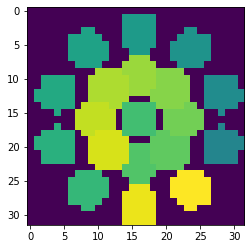

In [24]:
px = 32
py = 32
r = 3


def pixelate_frame(xy):
    """
    takes a single x,y pixel point and converts to binary image
    with ball centered at x,y.
    """
    rr = r*r
    x = xy[0]
    y = xy[1]

    sq_x = (np.arange(px) - x)**2
    sq_y = (np.arange(py) - y)**2

    sq = sq_x.reshape(1,-1) + sq_y.reshape(-1,1)

    image = 1*(sq < rr)

    return image


def pixelate_series(traj0):
    XY = traj0.copy()
    
    # convert trajectories to pixel dims
    XY[:,0] = XY[:,0] * (px/5) + (0.5*px)
    XY[:,1] = XY[:,1] * (py/5) + (0.5*py)
    

    

    vid = map(pixelate_frame, XY)
    vid = [v for v in vid]
    return np.asarray(vid)


def make_heatmap(vid):
    """
    args:
        vid: tmax, px, py
    returns:
        flat_vid: px, py
    """
    vid = np.array([(t+4)*v for t,v in enumerate(vid)])
    flat_vid = np.max(vid, 0)*(1/(4+30))
    return flat_vid
    

V = pixelate_series(traj00[0,:,:])
print(V.shape)

import matplotlib.pyplot as plt
plt.imshow(make_heatmap(V))

V = V.reshape((1,30,32,32))
print(V.shape)



Trainable variables:
<tf.Variable 'encW:0' shape=(1024, 500) dtype=float32_ref>
<tf.Variable 'encB:0' shape=(1, 500) dtype=float32_ref>
<tf.Variable 'encW_1:0' shape=(500, 4) dtype=float32_ref>
<tf.Variable 'encB_1:0' shape=(1, 4) dtype=float32_ref>
<tf.Variable 'decW:0' shape=(2, 500) dtype=float32_ref>
<tf.Variable 'decB:0' shape=(1, 500) dtype=float32_ref>
<tf.Variable 'decW_1:0' shape=(500, 1024) dtype=float32_ref>
<tf.Variable 'decB_1:0' shape=(1, 1024) dtype=float32_ref>
res_file: recovered 
INFO:tensorflow:Restoring parameters from /run/user/1000/gvfs/sftp:host=godzilla/home/maths/phrnaj/GPVAE_checkpoints/Ayman2/6:SIN_1__on__14_10_2019__at__15:41:55/model-50000


Restored Model Weights
50000: elbo -8772.639	 	 -6593.655  -2178.9844,		 qvar range:	 0.00054425 	 0.00014875675 ,		 qmean range:	 3.1781127 	 3.4309077
(1, 30, 2)


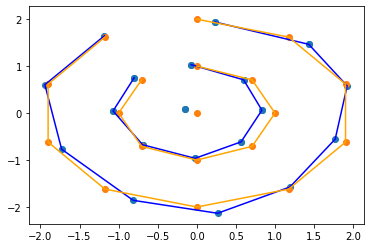

In [25]:
qnet_m = get_qnet(V)
print(qnet_m.shape)


rot_qnet, _, _, _ = MSE_rotation(qnet_m, traj00)

plt.scatter(rot_qnet[0,:,0],rot_qnet[0,:,1])
plt.scatter(traj0[:,0],traj0[:,1])

plt.plot(rot_qnet[0,1:9,0], rot_qnet[0,1:9,1], color='blue')
plt.plot(rot_qnet[0,9:19,0], rot_qnet[0,9:19,1],color='blue')

plt.plot(traj0[1:9,0], traj0[1:9,1], color='orange')
plt.plot(traj0[9:19,0], traj0[9:19,1],color='orange')


In [17]:
A = np.arange(10)
A[1:2]

array([1])